In [1]:
%matplotlib inline


Use Tensor Expression Debug Display (TEDD) for Visualization
============================================================
**Author**: `Yongfeng Gu <https://github.com/yongfeng-nv>`_

This is an introduction about using TEDD to visualize tensor expressions.

Tensor Expressions are scheduled with primitives.  Although individual
primitives are usually easy to understand, they become complicated quickly
when you put them together. We have introduced an operational model of
schedule primitives in Tensor Expression.

* the interactions between different schedule primitives,
* the impact of the schedule primitives on the final code generation.

The operational model is based on a Dataflow Graph, a Schedule Tree and an
IterVar Relationship Graph. Schedule primitives perform operations on these
graphs.

TEDD renders these three graphs from a given schedule.  This tutorial demonstrates
how to use TEDD and how to interpret the rendered graphs.




In [2]:
import tvm
from tvm import te
import topi
from tvm.contrib import tedd

Define and Schedule Convolution with Bias and ReLU
--------------------------------------------------
Let's build an example Tensor Expression for a convolution followed by Bias and ReLU.
We first connect conv2d, add, and relu TOPIs.  Then, we create a TOPI generic schedule.




In [3]:
batch = 1
in_channel = 256
in_size = 32
num_filter = 256
kernel = 3
stride = 1
padding = "SAME"
dilation=1

A = te.placeholder((in_size, in_size, in_channel, batch), name='A')
W = te.placeholder((kernel, kernel, in_channel, num_filter), name='W')
B = te.placeholder((1, num_filter, 1), name='bias')

with tvm.target.create("llvm"):
    t_conv = topi.nn.conv2d_hwcn(A, W, stride, padding, dilation)
    t_bias = topi.add(t_conv, B)
    t_relu = topi.nn.relu(t_bias)
    s = topi.generic.schedule_conv2d_hwcn([t_relu])

Render Graphs with TEDD
-----------------------
We render graphs to see the computation
and how it is scheduled.
If you run the tutorial in a Jupyter notebook, you can use the following commented lines
to render SVG figures showing in notebook directly.




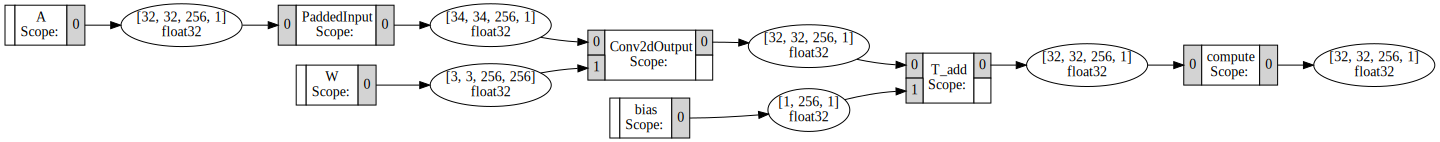

In [4]:
tedd.viz_dataflow_graph(s, dot_file_path = '/tmp/dfg.dot')
tedd.viz_dataflow_graph(s, show_svg = True)

![](https://github.com/dmlc/web-data/raw/master/tvm/tutorial/tedd_dfg.png)

     :align: center

The first one is a dataflow graph.  Every node represents a stage with name and memory
scope shown in the middle and inputs/outputs information on the sides.
Edges show nodes' dependency.




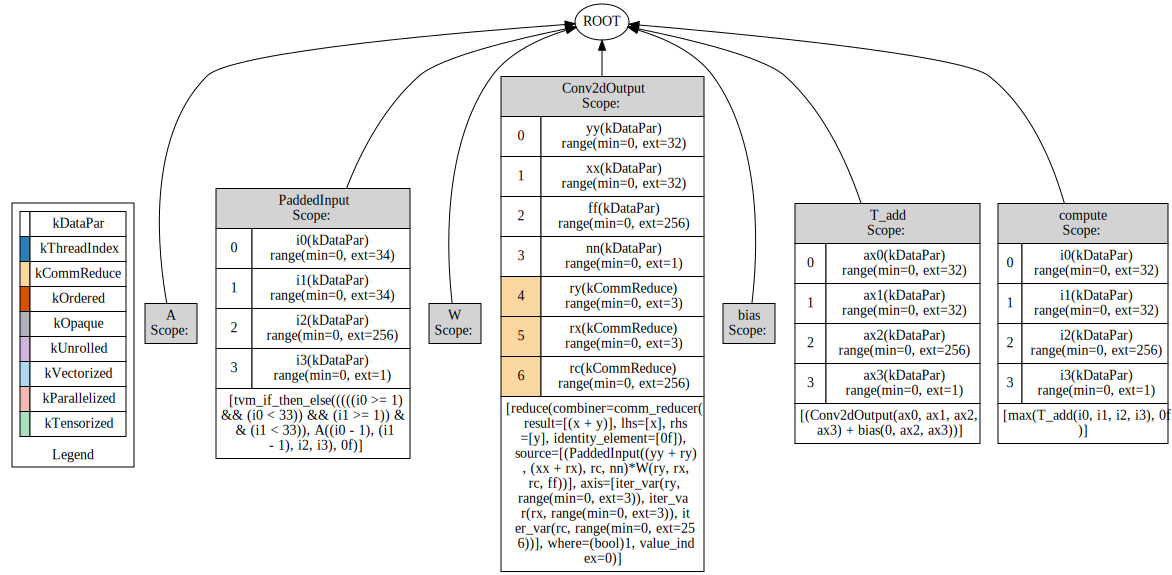

In [5]:
tedd.viz_schedule_tree(s, dot_file_path = '/tmp/scheduletree.dot')
tedd.viz_schedule_tree(s, show_svg = True)

We just rendered the schedule tree graph.  You may notice an warning about ranges not
available.
The message also suggests to call normalize() to infer range information.  We will
skip inspecting the first schedule tree and encourage you to compare the graphs before
and after normalize() for its impact.




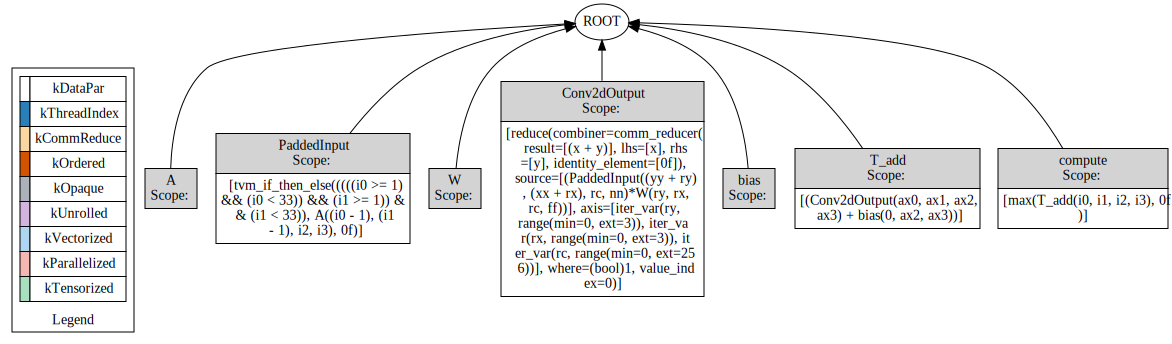

In [6]:
s = s.normalize()
tedd.viz_schedule_tree(s, dot_file_path = '/tmp/scheduletree2.dot')
tedd.viz_schedule_tree(s, show_svg = True)

![](https://github.com/dmlc/web-data/raw/master/tvm/tutorial/tedd_st.png)

     :align: center

Now, let us take a close look at the second schedule tree.  Every block under ROOT
represents a
stage.  Stage name shows in the top row and compute shows in the bottom row.
The middle rows are for IterVars, the higher the outer, the lower the inner.
An IterVar row contains its index, name, type, and other optional information.
Let's use the W.shared stage as an example.  The top row tells
its name, "W.shared", and memory scope, "Shared".  Its compute is
:code:`W(ax0, ax1, ax2, ax3)`.
Its outer most loop IterVar is ax0.ax1.fused.ax2.fused.ax3.fused.outer,
indexed with 0, of kDataPar, bound to threadIdx.y, and with range(min=0, ext=8).
You can also tell
IterVar type with the index box color, shown in the legend.

If a stage doesn't compute_at any other stage, it has an edge directly to the
ROOT node.  Otherwise, it has an edge pointing to the IterVar it attaches to,
such as W.shared attaches to rx.outer in the middle compute stage.




<div class="alert alert-info"><h4>Note</h4><p>By definition, IterVars are internal nodes and computes are leaf nodes in
  a schedule tree.   The edges among IterVars and compute within one stage are
  omitted, making every stage a block, for better readability.</p></div>




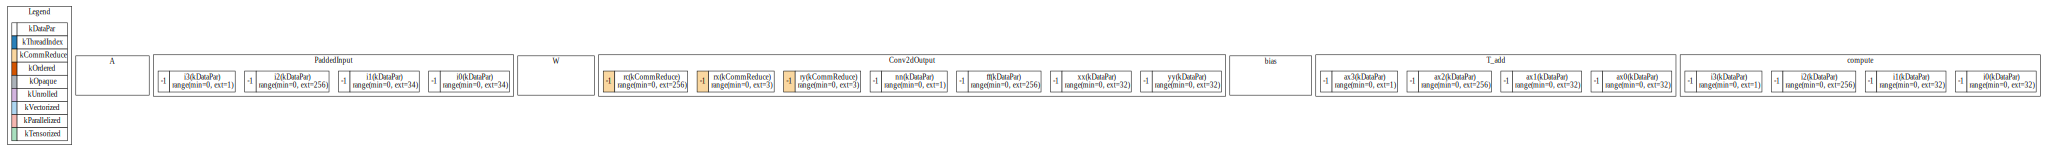

In [7]:
tedd.viz_itervar_relationship_graph(s, dot_file_path = '/tmp/itervar.dot')
tedd.viz_itervar_relationship_graph(s, show_svg = True)

![](https://github.com/dmlc/web-data/raw/master/tvm/tutorial/tedd_itervar_rel.png)

     :align: center

The last one is an IterVar Relationship Graph.  Every subgraph represents a
stage and contains IterVar nodes and transformation nodes.  For example,
W.shared has three split nodes and three fuse nodes.  The rest are IterVar
nodes of the same format as the IterVar rows in Schedule Trees.  Root
IterVars are those not driven by any transformation node, such as ax0; leaf
IterVars don't drive any transformation node and have non-negative indices,
such as ax0.ax1.fused.ax2.fused.ax3.fused.outer with index of 0.




Summary
-------
This tutorial demonstrates the usage of TEDD.  We use an example built
with TOPI to show the schedules under the hood.  You can also use
it before and after any schedule primitive to inspect its effect.


